In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
import os
import glob
from os import listdir
from os.path import isfile, join
%matplotlib inline

In [5]:
img = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#Note: If you are reading in an image using mpimg.imread() this will read in an RGB image 
#and you should convert to grayscale using cv2.COLOR_RGB2GRAY, 
#but if you are using cv2.imread() or the glob API, as happens in this video example, this will read in a BGR image and you should convert to grayscale using cv2.COLOR_BGR2GRAY. We'll learn more about color conversions later on in this lesson, but please keep this in mind as you write your own code and look at code examples.
gray = np.uint8(gray)
#Finding chessboard corners (for an 8x6 board)
ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
#Drawing detected corners on an image
img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
#Camera calibration, given object points, image points, and the shape of the grayscale image:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#Undistorting a test image:
dst = cv2.undistort(img, mtx, dist, None, mtx)

#plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


NameError: name 'objpoints' is not defined

In [ ]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image and grayscale it
image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
     # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
#sobel magnitute
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray,cv2.CV_64F, 1,0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel))
    
    # 3) Calculate the magnitude
    sobelxy = np.sqrt(np.add(np.square(sobelx),np.square(sobely)))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scaled = np.uint8(255*sobelxy/np.max(sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(sobel_scaled)
    # 6) Return this mask as your binary_output image
    binary_output[(sobel_scaled >= mag_thresh[0]) & (sobel_scaled <= mag_thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
#sobel gradient
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir)
    binary_output[(dir >= thresh[0]) & (dir<= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:

#Try different combinations and see what you get.

#For example, here is a selection for pixels where both the x and y gradients meet the threshold criteria, 
#or the gradient magnitude and direction are both within their threshold values.



combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

In [ ]:
#exercise to combine magnitude thresholding and gradient direction thresholding
#sobel gradient
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    return dir_binary

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

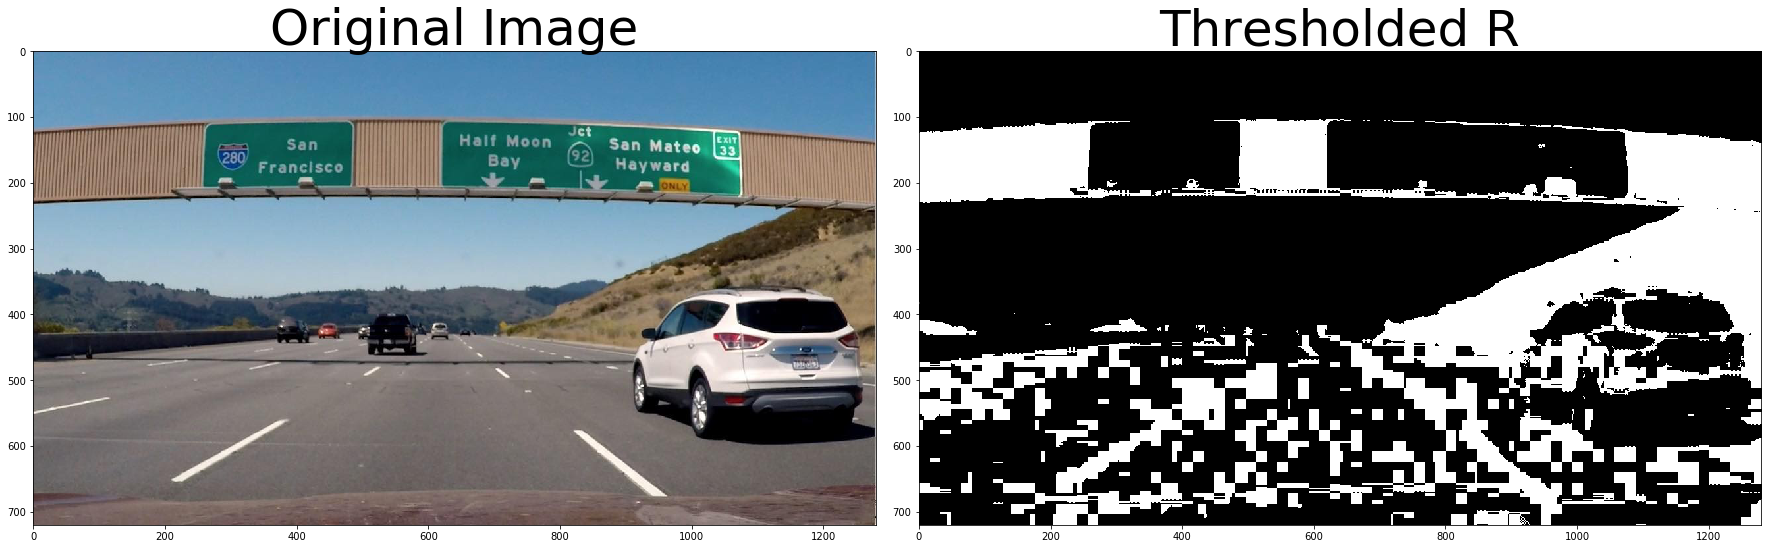

In [12]:
#threshold to identify lines
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png')
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1


#RGB thredholding
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1


thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Thresholded R', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()





<class 'numpy.ndarray'>
(720, 1280)


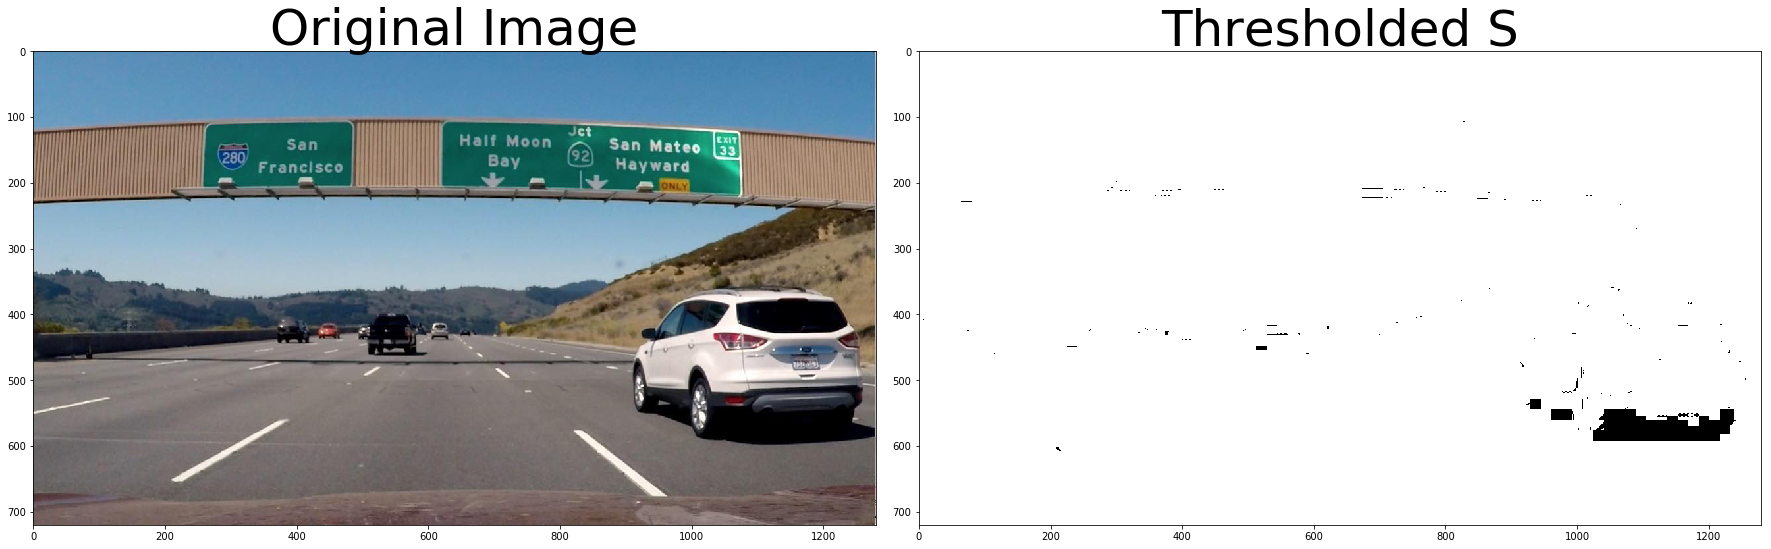

In [11]:
#HLS color space thresholding for lane lines


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S_channel = hls[:,:,2]
    print(type(S_channel))
    binary_output = np.zeros_like(S_channel)
    binary_output[(S_channel > thresh[0]) & (S_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output
    
hls_binary = hls_select(image)
print (hls_binary.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()





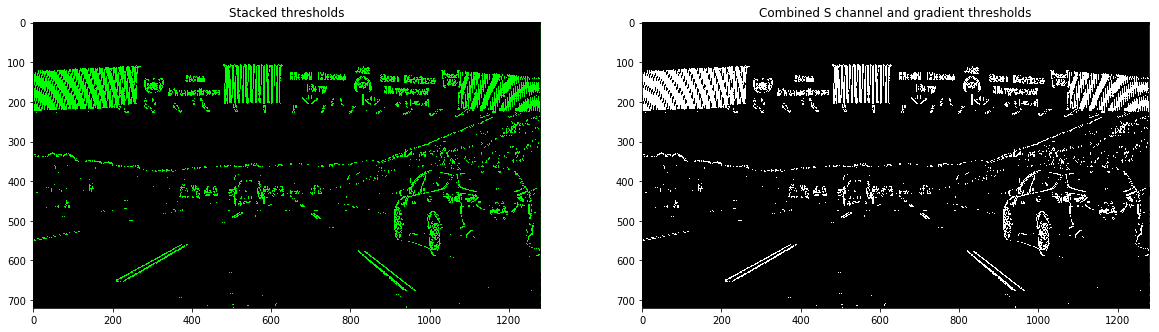

In [15]:

img = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png') 


# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()

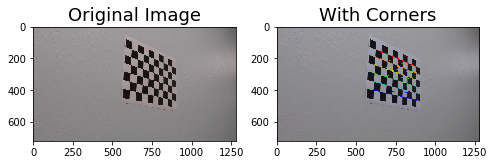

In [35]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
import os
import glob
from os import listdir
from os.path import isfile, join
%matplotlib inline

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.



def init():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg')

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)


    return objpoints, imgpoints

objpoints,imgpoints = init()
# Remove distortion from images
def undistort(image, show=True, read = True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=18)
    else:
        return undist

# Create binary thresholded images to isolate lane line pixels
# Perform perspective transform
def birds_eye(img, display=True, read = True):
    if read:
        undist = undistort(img, show = False)
    else:
        undist = undistort(img, show = False, read=False) 
        
    img_size = (undist.shape[1], undist.shape[0])
    print (undist.shape)
    #offset = 0
    #upper left=(490,482)
    #upper_right=(810,482)
    #lower_right=(1250,700)
    #lower_left=(40,720)
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        cv2.line(undist,(490,480),(810,480),(255,0,0),3)
        cv2.line(undist,(1250,720),(810,480),(255,0,0),3)
        cv2.line(undist,(40,720),(1250,720),(255,0,0),3)
        cv2.line(undist,(490,480),(40,720),(255,0,0),3)
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M


def apply_thresholds(image, show=True):
    img, M = birds_eye(image, display = False)
    

    HLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)    
    #h_channel = HLS[:,:,0]
    #l_channel = HLS[:,:,1]
    s_channel = HLS[:,:,2]
    
    
    LUV = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    l_channel = LUV[:,:,0]
    u_channel = LUV[:,:,1]
    v_channel = LUV[:,:,2]
    
    
    BGR2 = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    r_channel = BGR2[:,:,2]   
    #g2_channel = BGR[:,:,]
    #r2_channel = BGR[:,:,]
    
    
    # Threshold color channel
    s_thresh_min = 170 
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    r_thresh_min = 155
    r_thresh_max = 200
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (r_binary == 1)] = 1
    print('cb shape',combined_binary.shape)
    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Original Image', fontsize=16)
        ax1.imshow(cv2.cvtColor(undistort(image, show=False),cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax3.set_title('s binary threshold', fontsize=16)
        ax3.imshow(s_binary, cmap='gray')
        
        ax4.set_title('r binary threshold', fontsize=16)
        ax4.imshow(r_binary, cmap='gray')
        
        ax5.set_title('l binary threshold', fontsize=16)
        ax5.imshow(l_binary, cmap='gray')

        ax6.set_title('s+l+r thresholds', fontsize=16)
        ax6.imshow(combined_binary, cmap='gray')
        
        
    else: 
        return combined_binary

In [37]:
threshold = []
for image in glob.glob('test_images/test*.jpg'):
    thres_img = apply_thresholds(image,show=False)
    threshold.append(thres_img)

print (len(threshold))

(720, 1280, 3)
cb shape (720, 1280)
(720, 1280, 3)
cb shape (720, 1280)
(720, 1280, 3)
cb shape (720, 1280)
(720, 1280, 3)
cb shape (720, 1280)
(720, 1280, 3)
cb shape (720, 1280)
(720, 1280, 3)
cb shape (720, 1280)
6


In [ ]:
def find_lines(combined_binary):
    rightx = []
    righty = []
    leftx = []
    lefty = [] 
    
    x, y = np.nonzero(np.transpose(combined_binary))
    #there are 8 sliding windows here 630/90 + 1. Same as 720/90. 
    
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)

    return lefty, leftx, righty, rightx


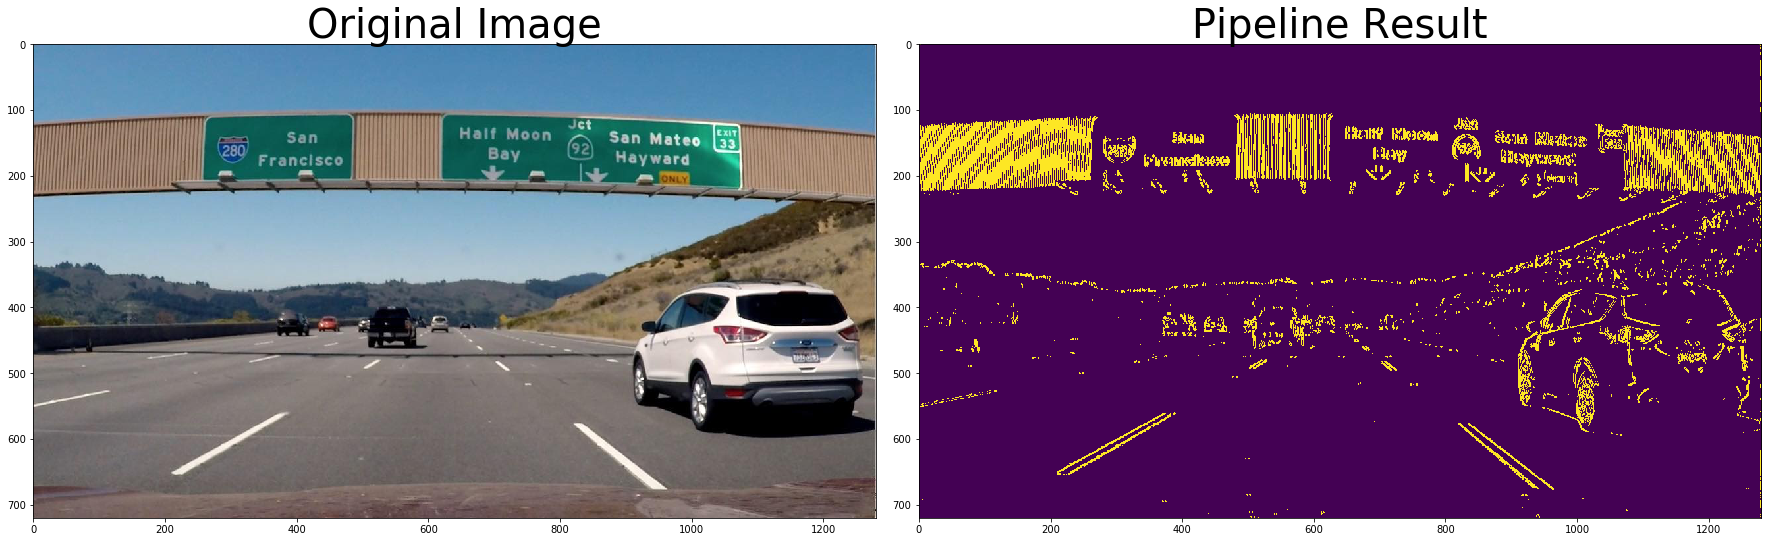

In [4]:
#stacking color binary and gradient binary

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    #
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [ ]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    return dir_binary


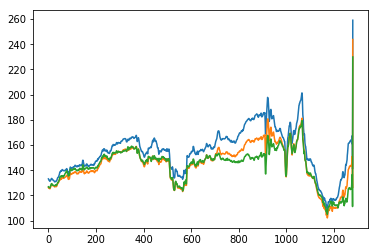

In [6]:
import numpy as np

img = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png')

histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
plt.plot(histogram)


test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


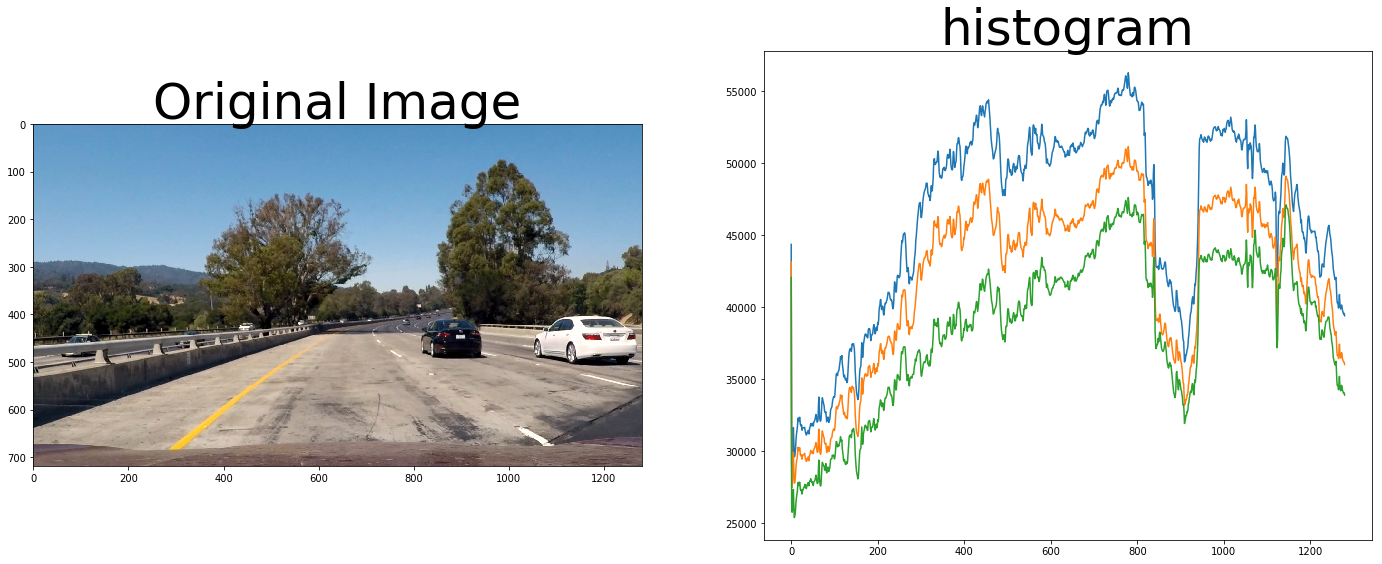

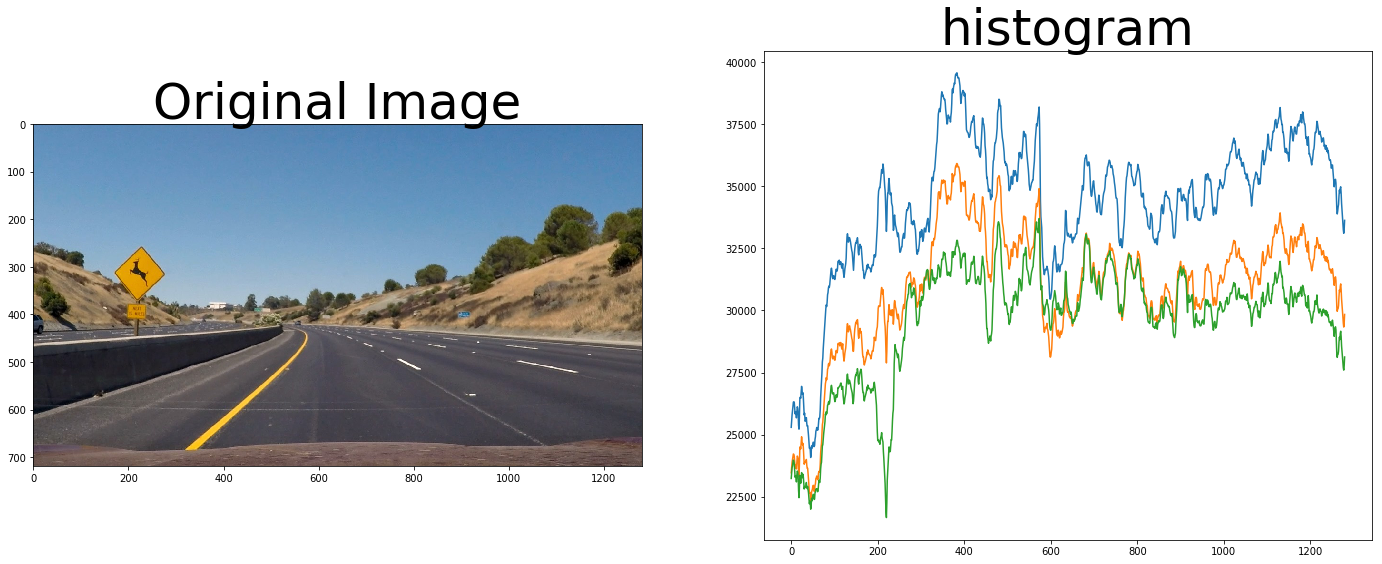

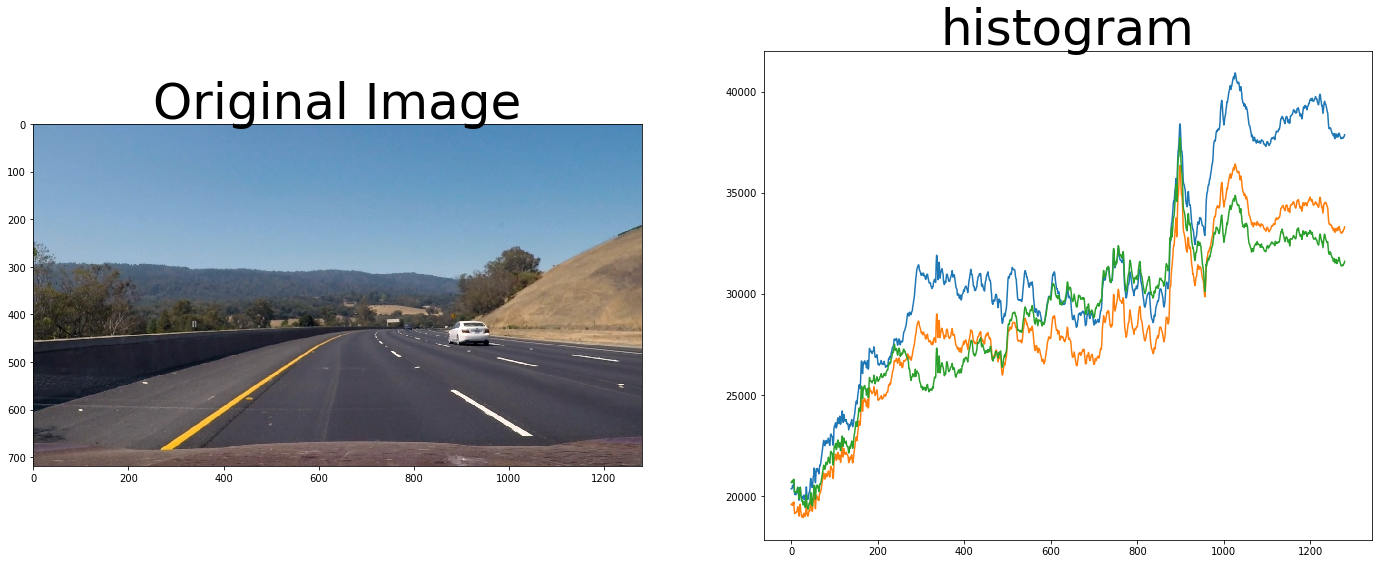

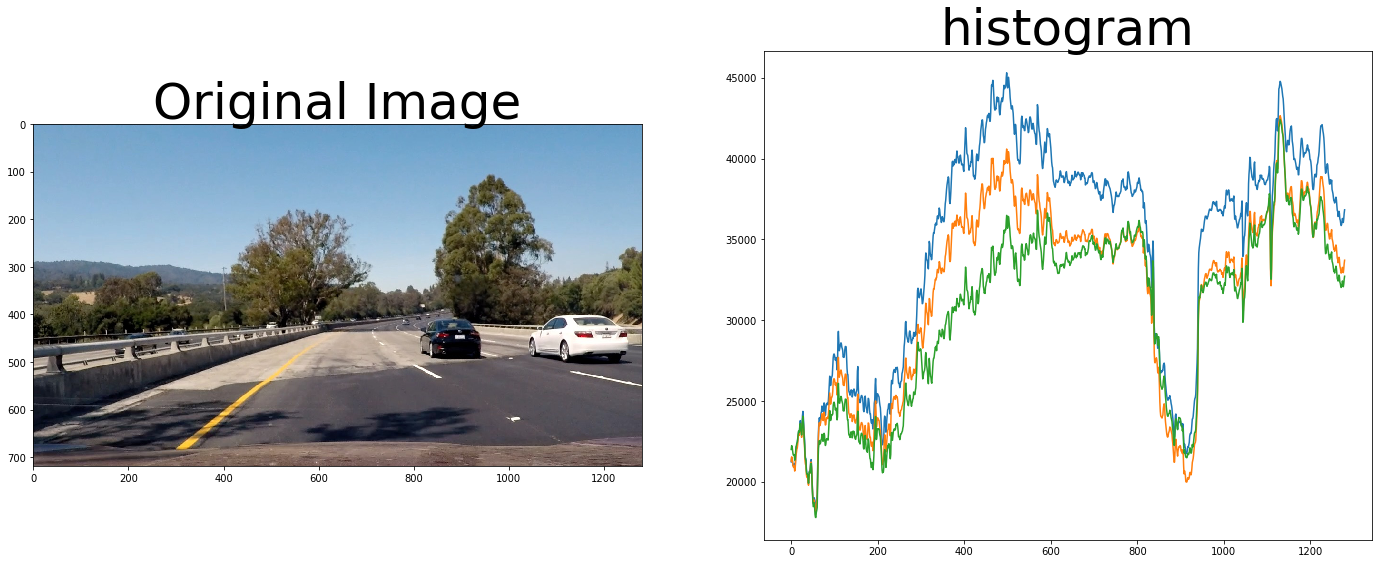

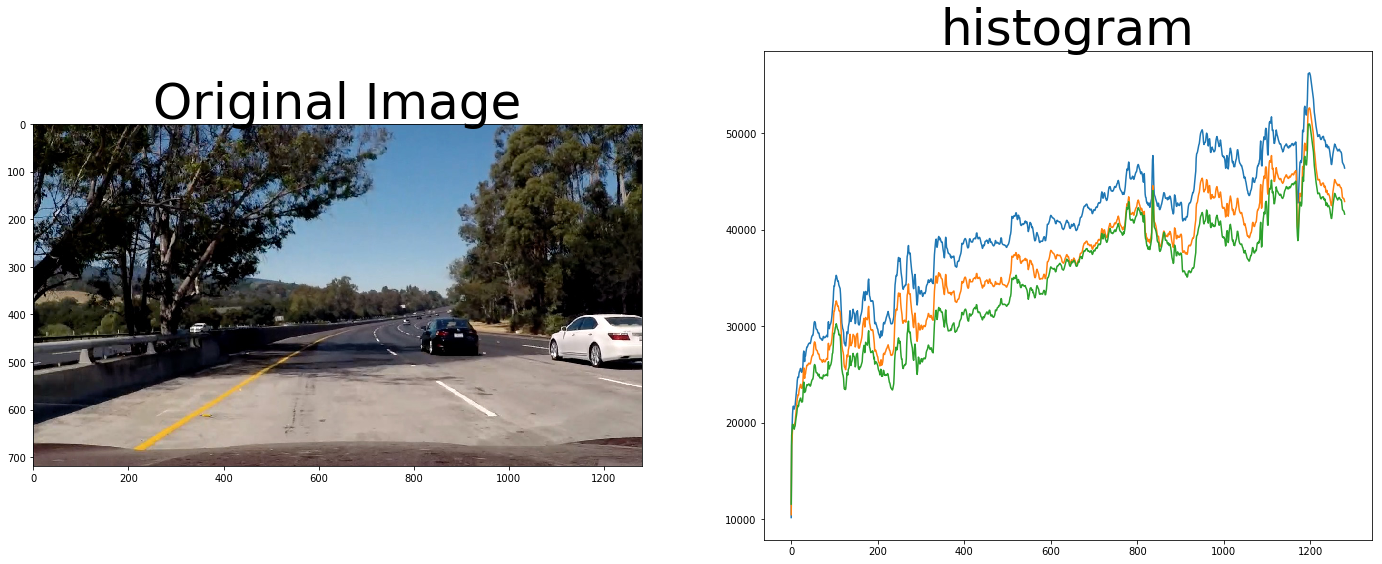

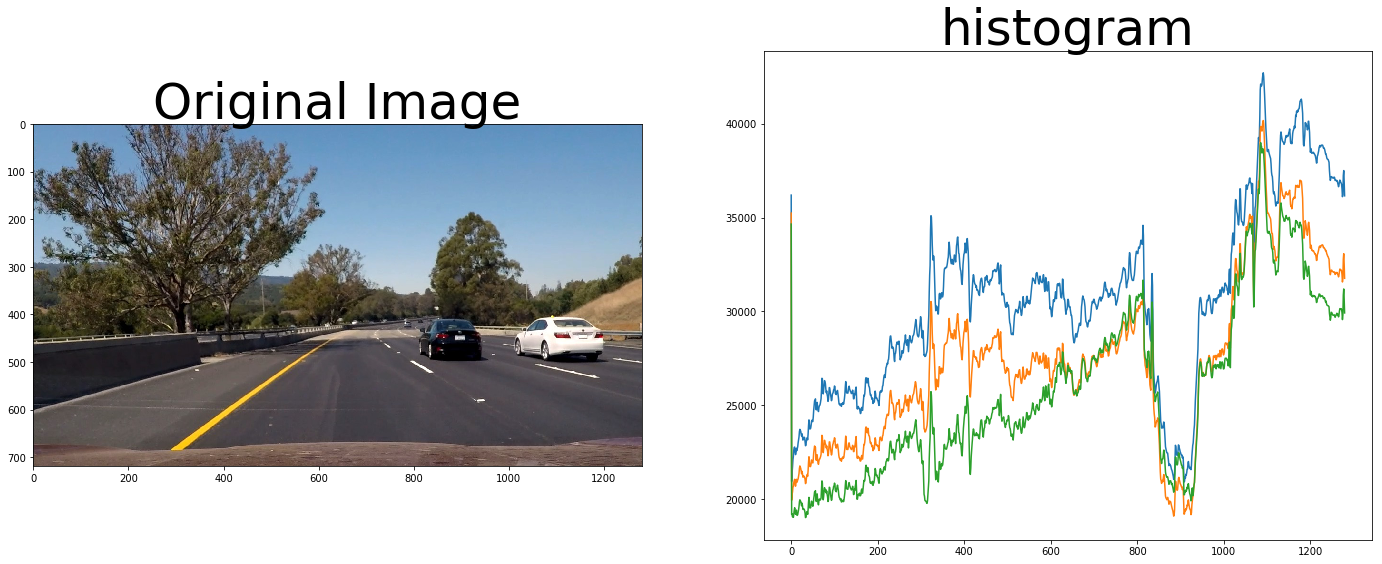

In [20]:
for img in glob.glob('test_images/test*.jpg'):
    print (img)
    image = mpimg.imread(img)
    

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(histogram, cmap='gray')
    histogram = np.sum(image[image.shape[0]/2:,:], axis=0)
    ax2.plot(histogram)
    ax2.set_title('histogram', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #well those don't look like what we saw in lecture

### note to myself. 
what is the difference between np.histogram and np.sum? I used to use np.histogram
np.histogram contains bins so you get bars vs. the jaggy lines in np.sum


In [49]:
#histogram of lower half of image
#import numpy as np
#image = mpimg.imread('/Users/dc/Desktop/signs_vehicles_xygrad.png')
#histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
#plt.plot(histogram)

#sliding windows and fit a polynomial
import numpy as np
import cv2
import matplotlib.pyplot as plt


#binary_warped = 
def blindsearch(binary_warped,show=True):
    print ('binary_warped shape:', binary_warped.shape)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    print('window_height:',window_height)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        print ('window:',window)
        print('leftx_current:',leftx_current, 'rightx_current',rightx_current)
        print('win_y_low',win_y_low,' win_y_high',win_y_high)
        print('win_xleft_low',win_xleft_low,' win_xleft_high',win_xleft_high)
        print('win_xright_low',win_xright_low,' win_xright_high',win_xright_high)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #Visualization
    #At this point, you're done! But here is how you can visualize the result as well:
    if (show==True):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #The output should look something like this:
    else:
        return left_fit,right_fit
    

binary_warped shape: (720, 1280)
window_height: 80
window: 0
leftx_current: 254 rightx_current 1178
win_y_low 640  win_y_high 720
win_xleft_low 154  win_xleft_high 354
win_xright_low 1078  win_xright_high 1278
window: 1
leftx_current: 254 rightx_current 1178
win_y_low 560  win_y_high 640
win_xleft_low 154  win_xleft_high 354
win_xright_low 1078  win_xright_high 1278
window: 2
leftx_current: 242 rightx_current 1183
win_y_low 480  win_y_high 560
win_xleft_low 142  win_xleft_high 342
win_xright_low 1083  win_xright_high 1283
window: 3
leftx_current: 248 rightx_current 1183
win_y_low 400  win_y_high 480
win_xleft_low 148  win_xleft_high 348
win_xright_low 1083  win_xright_high 1283
window: 4
leftx_current: 254 rightx_current 1183
win_y_low 320  win_y_high 400
win_xleft_low 154  win_xleft_high 354
win_xright_low 1083  win_xright_high 1283
window: 5
leftx_current: 260 rightx_current 1123
win_y_low 240  win_y_high 320
win_xleft_low 160  win_xleft_high 360
win_xright_low 1023  win_xright_high 

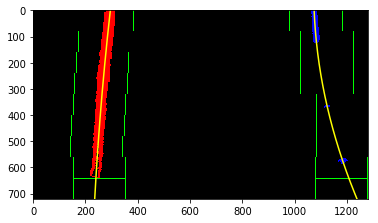

In [50]:
blindsearch(threshold[0]);

(720, 0)

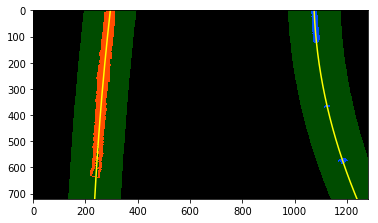

In [44]:
#Skip the sliding windows step once you know where the lines are
#Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again, 
#but instead you can just search in a margin around the previous line position like this:

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#the blue line doesnt draw all way through

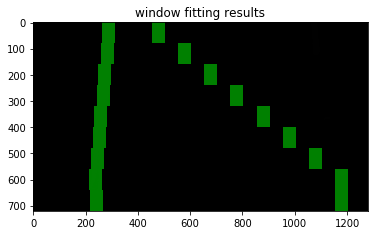

In [52]:
#sliding window search via convolution

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
warped = threshold[0]
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


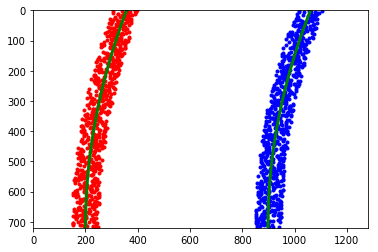

In [53]:
# radius of curvature

import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images




In [54]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1649.65437616 1568.9559685


In [55]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

541.83465752 m 515.320464459 m


In [57]:
 #You need to set your chessboard size to 9x6 for the project instead of 8x6 as in the lesson.
 #Define a line class for left and right lanes to keep track of recent detections and perform sanity checks   
    
    class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

SyntaxError: invalid syntax (<ipython-input-57-41cc760bfe4f>, line 1)

In [56]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

NameError: name 'Minv' is not defined